In [54]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
from exp.nb_01 import *
from fastai import datasets
from torch import nn
import torch.nn.functional as F

In [56]:
#export
def get_data():
    path=datasets.download_data(MNIST_URL,ext='.gz')
    with gzip.open(path) as f:
        ((x_train,y_train),(x_valid,y_valid),_)=pickle.load(f,encoding='latin-1')
    return map(tensor,(x_train,y_train,x_valid,y_valid))

def normalize(x,m,s):return (x-m)/s
def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)

In [12]:
def get_stats(x):
    return x.mean(),x.std()

In [6]:
x_train,y_train,x_valid,y_valid=get_data()

In [9]:
train_mean=x_train.mean()
train_std=x_train.std()

In [11]:
#Step1 We normalize our input. We normalize input because actual input values can contain very high numbers
#repeated multiplication can explode those numbers and hence it will be very hard for SGD to converge. 
# Rember when we normalize we normalize both the train data and valid data with same mean and standard variation.
# Otherwise they will be statistically different.
x_train=normalize(x_train,train_mean,train_std)
x_valid=normalize(x_valid,train_mean,train_std)
x_train.mean(),x_valid.mean()

(tensor(-0.4239), tensor(-0.4437))

In [14]:
n,m=x_train.shape
c=y_train.max()+1
nh=50
n,m,c,nh

(50000, 784, tensor(10), 50)

In [19]:
class Model(nn.Module):
    def __init__(self,n_in,n_h,n_out):
        super().__init__()
        self.layers=[nn.Linear(n_in,n_h),nn.ReLU(),nn.Linear(n_h,n_out)]
    def __call__(self,x):
        for l in self.layers:x=l(x)
        return x

In [20]:
model=Model(m,nh,10)

In [21]:
pred=model(x_train)

In [22]:
#We just ran once and get pred
pred

tensor([[ 1.1365,  0.1784,  0.3573,  ...,  0.4475,  0.1477,  0.2556],
        [ 0.9111,  0.1356,  0.8911,  ...,  0.1095,  0.2561,  0.5328],
        [-0.1127,  0.5313,  1.5855,  ...,  0.4406,  2.2535, -0.3431],
        ...,
        [ 1.2885,  1.0124,  1.3355,  ..., -0.8332,  1.0287, -0.3092],
        [ 1.9323,  0.7244,  1.2166,  ...,  0.1089,  0.7854,  0.7096],
        [ 0.7867,  0.6502,  0.6499,  ..., -0.4622,  0.6458,  0.1509]],
       grad_fn=<AddmmBackward>)

In [23]:
#Lets use Cross Entropy as loss function
#Cross entropy calculated as 
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [24]:
sm_pred=log_softmax(pred)

In [25]:
y_train[0:4]

tensor([5, 0, 4, 1])

In [27]:
sm_pred[[0,1,2], [5,0,4]]

tensor([-3.1463, -1.9979, -3.1365], grad_fn=<IndexBackward>)

In [38]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [39]:
loss = nll(sm_pred, y_train)

In [40]:
loss

tensor(2.4100, grad_fn=<NegBackward>)

In [32]:
# We can rewrite log_softmax function by using log rules
def log_softmax(x): return x - (x.exp().sum(-1,keepdim=True)).log()

In [42]:
test_near(nll(log_softmax(pred),y_train),loss)

In [58]:
test_near(F.nll_loss(F.log_softmax(pred,-1),y_train),loss)

### So what we achieved till now 
### We created our own model and we run a single forward pass
### Instead of using MSE as loss function we use log_softmax, we add negative log loss on that softmax
### We use nll_lose and log_softmax from pytorch and prove both result are actually same

### Batch training Model and BackPropagation 

In [61]:
loss_func=F.cross_entropy

In [62]:
F.cross_entropy??

In [63]:
#export
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [66]:
#Now we will train our model based on batch
bs=64
xb=x_train[0:bs]
yb=y_train[0:bs]
preds=model(xb)
xb.shape,yb.shape,preds.shape

(torch.Size([64, 784]), torch.Size([64]), torch.Size([64, 10]))

In [68]:
loss_func(preds,yb)

tensor(2.4785, grad_fn=<NllLossBackward>)

In [69]:
accuracy(preds,yb)

tensor(0.1094)

In [70]:
lr=0.1
epoch=10

In [75]:
for e in range(epoch):
    for i in range((n-1)//bs+1):
        start_i=i*bs
        end_i=start_i+bs
        xb=x_train[start_i:end_i]
        yb=y_train[start_i:end_i]
        loss=loss_func(model(xb),yb)
        loss.backward()
        
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l,'weight'):
                    l.weight-=l.weight.grad*lr
                    l.bias-=l.bias.grad*lr
                    l.weight.grad.zero_()
                    l.bias.grad.zero_()

In [76]:
loss_func(model(xb),yb), accuracy(model(xb),yb)

(tensor(0.0020, grad_fn=<NllLossBackward>), tensor(1.))

In [78]:
for e in range(epoch):
    for i in range((n-1)//bs+1):
        start_i=i*bs
        end_i=start_i+bs
        xb=x_train[start_i:end_i]
        yb=y_train[start_i:end_i]
        loss=loss_func(model(xb),yb)
        loss.backward()
        
        with torch.no_grad():
            for p in model.parameters():
                p-=p.grad*lr
                model.zero_grad()
   

In [79]:
loss_func(model(xb),yb), accuracy(model(xb),yb)

(tensor(0.0020, grad_fn=<NllLossBackward>), tensor(1.))

In [80]:
## Till now our model has hard coded layers , what if we can pass the layers are argument when we create the module. 


In [95]:
class SequentialModel(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.layers=layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}',l)
    def __call__(self,x):
        for l in self.layers: x=l(x)
        return x

In [96]:
layers=[nn.Linear(m,nh),nn.ReLU(),nn.Linear(nh,10)]
model=Model(layers)

In [97]:
model

Model(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [98]:
## We can refactor better using modulelist
class SequentialModel(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.layers=nn.ModuleList(layers)
        
    def __call__(self,x):
        for l in self.layers: x=l(x)
        return x

In [99]:
model

Model(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [100]:
#Our hand made class can be replaced with
nn.Sequential??

In [101]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()
        
        

In [102]:
model=nn.Sequential(nn.Linear(m,nh),nn.ReLU(),nn.Linear(nh,10))

In [103]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

In [109]:
opt=Optimizer(model.parameters(),0.1)

In [110]:
opt

In [111]:
for e in range(epoch):
    for i in range((n-1)//bs+1):
        start_i=i*bs
        end_i=start_i+bs
        xb=x_train[start_i:end_i]
        yb=y_train[start_i:end_i]
        loss=loss_func(model(xb),yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
        

In [112]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(2.3232, grad_fn=<NllLossBackward>), tensor(0.))

In [113]:
#export
from torch import optim

In [114]:
optim.SGD??

In [115]:
#export
def get_model():
    model=nn.Sequential(nn.Linear(m,nh),nn.ReLU(),nn.Linear(nh,10))
    opt=optim.SGD(model.parameters(),lr=0.1)
    return model,opt

In [116]:
model,opt=get_model()
for e in range(epoch):
    for i in range((n-1)//bs+1):
        start_i=i*bs
        end_i=start_i+bs
        xb=x_train[start_i:end_i]
        yb=y_train[start_i:end_i]
        loss=loss_func(model(xb),yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

In [117]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
loss,acc

(tensor(0.0006, grad_fn=<NllLossBackward>), tensor(1.))

In [119]:
## 1. run forward pass, 2. run loss function, 3. loss.backward(), 4. upgrade model grad, 5. 


In [165]:
#export
class Dataset():
    def __init__(self,x,y):
        self.x=x
        self.y=y
    def __getitem__(self,i):
        return self.x[i],self.y[i]
    def __len__(self): return len(self.x)

In [123]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [125]:
model,opt=get_model()
for e in range(epoch):
    for i in range((n-1)//bs+1):
        start_i=i*bs
        end_i=start_i+bs
        xb,yb=train_ds[start_i:end_i]
        loss=loss_func(model(xb),yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

In [127]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.0032, grad_fn=<NllLossBackward>), tensor(1.))

In [173]:
class DataLoader():
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [174]:
model,opt=get_model()
trains_dl=DataLoader(train_ds,bs=64)
for e in range(epoch):
    for xb,yb in trains_dl:
        predict=model(xb)
        loss=loss_func(predict,yb)
        loss.backward()
        opt.step()
        opt.zero_grad()

In [130]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.0020, grad_fn=<NllLossBackward>), tensor(1.))

In [131]:
def fit():
    for e in range(epoch):
        for xb,yb in trains_dl:
            predict=model(xb)
            loss=loss_func(predict,yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
    

In [132]:
fit()

In [133]:
loss,acc = loss_func(model(xb), yb), accuracy(model(xb), yb)
assert acc>0.7
loss,acc

(tensor(0.0003, grad_fn=<NllLossBackward>), tensor(1.))

In [134]:
## Add sampling capability
class Sampler():
    def __init__(self,ds,bs,shuffle=True):
        self.n,self.bs,self.shuffle=len(ds),bs,shuffle
    def __iter__(self):
        self.idxs = torch.randperm(self.n) if self.shuffle else torch.arange(self.n)
        for i in range(0, self.n, self.bs): yield self.idxs[i:i+self.bs]

In [135]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

class DataLoader():
    def __init__(self, ds, sampler, collate_fn=collate):
        self.ds,self.sampler,self.collate_fn = ds,sampler,collate_fn
        
    def __iter__(self):
        for s in self.sampler: yield self.collate_fn([self.ds[i] for i in s])

In [137]:
train_dl=DataLoader(train_ds,Sampler(train_ds,bs))

tensor(6)

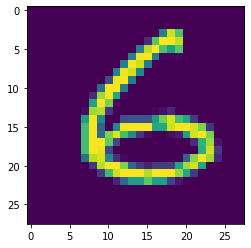

In [144]:
xb,yb=next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

## Now time to use pytorch data loader

In [145]:
#export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

In [147]:
train_dl=DataLoader(train_ds,bs,sampler=RandomSampler(train_ds),collate_fn=collate)
valid_dl=DataLoader(valid_ds,bs,sampler=SequentialSampler(valid_ds),collate_fn=collate)

tensor(0)

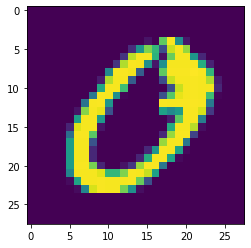

In [149]:
xb,yb=next(iter(train_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [150]:
fit()

In [151]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

(tensor(0.2056, grad_fn=<NllLossBackward>), tensor(0.9375))

In [159]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    model.train()
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred=model(xb)
            loss=loss_func(pred,yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()

        with torch.no_grad():
            tot_loss,tot_acc = 0.,0.
            for xb,yb in valid_dl:
                pred=model(xb)
                tot_loss+=loss_func(pred,yb)
                tot_acc+=accuracy(pred,yb)
        nv=len(valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv 

In [160]:
model,opt=get_model()
fit(10,model,F.cross_entropy,opt,train_dl,valid_dl)

0 tensor(0.2398) tensor(0.9305)
1 tensor(0.1351) tensor(0.9602)
2 tensor(0.1765) tensor(0.9513)
3 tensor(0.1665) tensor(0.9614)
4 tensor(0.1269) tensor(0.9667)
5 tensor(0.2314) tensor(0.9430)
6 tensor(0.1445) tensor(0.9650)
7 tensor(0.3164) tensor(0.9296)
8 tensor(0.1882) tensor(0.9584)
9 tensor(0.1410) tensor(0.9658)


(tensor(0.1410), tensor(0.9658))

In [162]:
#export
def get_dls(train_ds,valid_ds,bs,**kwargs):
    return DataLoader(train_ds,bs,shuffle=True,**kwargs),DataLoader(valid_ds,bs,**kwargs)

In [163]:
train_dl,valid_dl=get_dls(train_ds,valid_ds,bs)
model,opt=get_model()
fit(5,model,F.cross_entropy,opt,train_dl,valid_dl)

0 tensor(0.2398) tensor(0.9239)
1 tensor(0.2454) tensor(0.9328)
2 tensor(0.4536) tensor(0.8695)
3 tensor(0.1328) tensor(0.9640)
4 tensor(0.1271) tensor(0.9678)


(tensor(0.1271), tensor(0.9678))

In [175]:
!python notebook2script.py 03_minibatch_training.ipynb

Converted 03_minibatch_training.ipynb to exp/nb_03.py
